In [1]:
%load_ext autoreload
import pickle
import sys
sys.path.append('../../..')
import numpy as np
from scipy.interpolate import interp1d
from tqdm import tqdm_notebook as tqdm

import config
import darkhistory.physics as phys
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.low_energy.atomic as atomic
import darkhistory.low_energy.bound_free as bf
from plotting_utils import plot_distortion, download_plot

import matplotlib
matplotlib.rc_file('../../../matplotlibrc')
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as colors
%matplotlib inline

hplanck = phys.hbar * 2 * np.pi

output_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/output/'
fig_dir = '/Users/viviesque/OneDrive - Massachusetts Institute of Technology/DarkHistory/figs/'

Jens Chluba and collaborators have thoroughly computed the full Standard Model CMB distortion from recombination as well as various individual contributions.  In this cross-check we compare against Fig. 1 of [astro-ph/0608120](https://arxiv.org/pdf/astro-ph/0608120v1.pdf) and Fig. 3 of [astro-ph/0607373v1](https://arxiv.org/pdf/astro-ph/0607373v1.pdf) to test the bound-bound dipolar transitions, 1s-2s transition, and bound-free transitions.

In [2]:
# Create 2s -> 1s spectrum
eng = np.exp(np.linspace(
    np.log(hplanck*1e8), np.log(phys.rydberg), 500))

nmax_list = [10,20,30,100]

In [3]:
%autoreload
cf=4
dlnz = -.001*cf
rs_vec = np.exp(np.arange(np.log(3.5e3), np.log(5e2), dlnz))

# Load old runs
load = True

# Dictionary containing different types of distortions
distortion_dict = {}

if load:
    distortion_dict = pickle.load(open(output_dir+'recombination_distortions.p','rb'))
else:
    for nmax in nmax_list:
        if nmax==100:
            include_2s1s, include_BF = True, True
        else:
            include_2s1s, include_BF = False, False

        key = str(nmax)
        if include_2s1s:
            key += '_2s'
        if include_BF:
            key += 'BF'
        if key not in distortion_dict:
            distortion_dict[key] = Spectrum(
                eng, np.zeros_like(eng), spec_type='N', rs=1)
        else:
            distortion_dict[key].N *= 0

        # Store individual components of the distortion
        delta_dists = Spectra(
            np.zeros((len(rs_vec), len(eng))), 
            eng=eng, spec_type='N', rs=rs_vec)
        
        R = atomic.populate_radial(nmax)
        Thetas = bf.populate_thetas(nmax)

        # Build up the distortion one redshift at a time
        for i, rs in enumerate(tqdm(rs_vec)):
            dt = -dlnz/phys.hubble(rs)
            xHI = phys.x_std(rs, 'HI')
            Tm = phys.Tm_std(rs)

            _, transition_spec = atomic.process_MLA(
                rs, dt, xHI, Tm, nmax, eng, R, Thetas,
                Delta_f=None, cross_check=False,
                include_2s1s=include_2s1s, include_BF=include_BF
            )

            delta_dists._grid_vals[i] = transition_spec.N
            transition_spec.redshift(1)
            distortion_dict[key] += transition_spec.N
        pickle.dump(distortion_dict, open(output_dir+'recombination_distortions.p', 'wb'))

In [5]:
%autoreload
n10_data = download_plot('n10', input_dir=config.data_path)
n20_data = download_plot('n20', input_dir=config.data_path)
n30_data = download_plot('n30', input_dir=config.data_path)
jens_data = download_plot('Full_Distortion', input_dir=config.data_path)
jens_2s = download_plot('DeltaR_2s_Jens', input_dir=config.data_path)
jens_2p = download_plot('DeltaR_2p_Jens', input_dir=config.data_path)
BB_BF_jens = download_plot('BB_plus_BF_dist', input_dir=config.data_path)

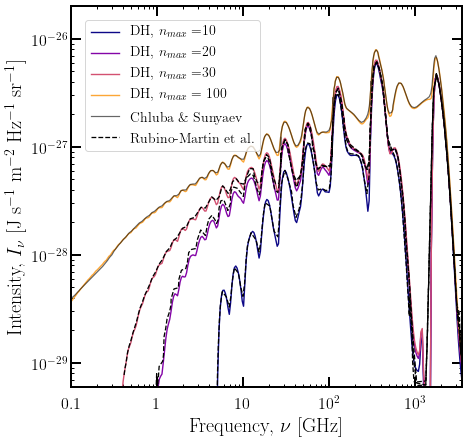

In [12]:
hplanck = phys.hbar * 2*np.pi
convert = phys.nB * eng * hplanck * phys.c /(4*np.pi) * phys.ele * 1e4
nu = eng/hplanck
rs_fac = 1300

plt.figure(figsize=(7, 7))
plt.loglog()
plt.xlim([1e-1, 3.5e3])
plt.ylim([6e-30, 2e-26])

# DH generated data
ns = ['10','20','30','100_2sBF']
colors = cm.plasma(np.linspace(0.,0.8,4))
labels = ['DH, $n_{max}=$'+nmax if nmax != '100_2sBF' else 'DH, $n_{max}=100$' for nmax in ns]

for i,nmax in enumerate(ns):
    plt.plot(nu/1e9, convert * distortion_dict[nmax].dNdE,
             color=colors[i], linewidth=1.4, label=labels[i])
# plt.plot(nu/1e9, convert * goods['distortion'].dNdE)

# Data from Jens Chluba et al's papers
plt.plot(BB_BF_jens[:,0], BB_BF_jens[:,1], color='k',
         linewidth=1.2, label='Chluba \& Sunyaev', alpha=0.6)
plt.plot(n10_data[:,0], n10_data[:,1],'k--',
         linewidth=1.3, label='Rubino-Martin et al.')
plt.plot(n20_data[:,0], n20_data[:,1], 'k--', linewidth=1.3)
plt.plot(n30_data[:,0], n30_data[:,1], 'k--', linewidth=1.3)
# plt.plot(jens_data[:,0], jens_data[:,1], 'k--', linewidth=1.3)

plt.legend(loc=2, fontsize=14)

plt.xlabel(r'Frequency, $\nu$ [GHz]', fontsize=20)
plt.ylabel(r'Intensity, $I_{\nu}$ [J s$^{-1}$ m$^{-2}$ Hz$^{-1}$ sr$^{-1}$]', fontsize=20)
if cf>1 and (not load):
    print('WARNING: There are extra errors from coarsening')
    
plt.savefig(fig_dir+'recombination_distortion.pdf')